### This notebook ingests CMIP6 ESM data and makes a figure that shows geographical variation in the carbon feedbacks on land and ocean

#### first load libraries

In [1]:
from __future__ import print_function

import numpy as np
import sys
#
import xarray as xr
import xesmf as xe

import warnings; warnings.simplefilter('ignore')
#
from scipy.io import netcdf  ## to write netcdf file
import datetime

import requests
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy

import matplotlib

import matplotlib.gridspec as gridspec


#### this is a function to find a given file within a list of full-path filenames and return the full-path version

In [2]:
def substitute_filename(filename_in, filelist_file):
    # look up in a giant file list to find the location of a given file
    with open(filelist_file) as f:
        for line in f:
            if filename_in in line:
                return(line.strip())
    raise(RuntimeError)

In [3]:
matplotlib.__version__

'3.3.1'

#### these functions search the ESG for files that match a given set of criteria (experiment, variable, model name, etc). Note that they can return files that are served either by http for downloading or via opendap for direct remote access.

In [4]:
# Author: Unknown
# I got the original version from a word document published by ESGF
# https://docs.google.com/document/d/1pxz1Kd3JHfFp8vR2JCVBfApbsHmbUQQstifhGNdc6U0/edit?usp=sharing

# API AT: https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API#results-pagination

def esgf_search(server="https://esgf-node.llnl.gov/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CMIP6",
                verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    offset = 0
    numFound = 10000
    all_files = []
    #files_type = files_type.upper()
    while offset < numFound:
        payload["offset"] = offset
        url_keys = [] 
        for k in payload:
            url_keys += ["{}={}".format(k, payload[k])]

        url = "{}/?{}".format(server, "&".join(url_keys))
        ##cdk print(url)
        r = client.get(url)
        r.raise_for_status()
        resp = r.json()["response"]
        numFound = int(resp["numFound"])
        resp = resp["docs"]
        offset += len(resp)
        for d in resp:
            if verbose:
                for k in d:
                    print("{}: {}".format(k,d[k]))
            url = d["url"]
            for f in d["url"]:
                sp = f.split("|")
                ###print(sp)  ##++cdk
                if sp[-1] == files_type:
                    all_files.append(sp[0].split(".html")[0])
    return sorted(all_files)

def lookup_esg(model,exp,var, filename):
    urllist = esgf_search(variable_id=var, experiment_id=exp, source_id=model, files_type="HTTPServer")
    for url in urllist:
        if filename in url:
            return(url)
    raise(RuntimeError)

#### this function takes monthly data and returns annualized data, calcualted as weighted means of the uneven month length (assuming a 365-day or no-leap calendar)

In [5]:
def monthly_to_annual(array):
    mon_day  = xr.DataArray(np.array([31.,28.,31.,30.,31.,30.,31.,31.,30.,31.,30.,31.]), dims=['month'])
    mon_wgt  = mon_day/mon_day.sum()
    return (array.rolling(time=12, center=False) # rolling
            .construct("month") # construct the array
            .isel(time=slice(11, None, 12)) # slice so that the first element is [1..12], second is [13..24]
            .dot(mon_wgt, dims=["month"]))

#### here are the main arguments in the notebook.  specify what models, variables, experiments to use, what time-points to evaluate at, and what output resolution to regrid variables to.  
#### Also creates a main repository to store all the file names used here, structured as a nested list of lists of lists of lists, structured, from outermost to innermost lists, by model names, then variables, then experiments, then the temporal sequence of files for a given model/experiment/variable combination.

In [6]:
models_list = (
    'CanESM5',
    'CESM2',
    'CNRM-ESM2-1',
    'IPSL-CM6A-LR',
    'MIROC-ES2L',
    'UKESM1-0-LL',
    'ACCESS-ESM1-5',
    'MPI-ESM1-2-LR',
    'GFDL-ESM4'
    )
# 'GISS-E2-1-G',

exps_list = ('piControl','1pctco2-bgc','1pctco2')

vars_list = ('tas','fgco2','netAtmosLandCO2Flux')

nmodels = len(models_list)
nvars = len(vars_list)
nexps = len(exps_list)

file_main_list_dynamics = [[[[] for i in range(nexps )] for j in range(nvars)] for k in range(nmodels)]
### index this file as [model_i][var_i][exp_i]

y_4xco2 = 140 - 1
t_4xco2 = (y_4xco2+1)*12-1
y_2xco2 = 70 - 1
t_2xco2 = (y_2xco2+1)*12-1

regrid_lons = np.arange(-179.5,180.5,1.)
regrid_lats = np.arange(-89.5,90.5,1.)

IM_o = len(regrid_lons)
JM_o = len(regrid_lats)

# make a dataset on the new grid
ds_out = xr.Dataset({'lat': (['lat'], regrid_lats),
                     'lon': (['lon'], regrid_lons),
                    })

model_indices = np.arange(nmodels,dtype=np.int)

### assume uniform CO2 trajectories as if all the models followed the protocol
pico2 = 284.7
delta_co2_ppm_4xco2 = 3.*pico2

fgco2_unit_conversion_factor = np.ones(nmodels)

filename_lookup = '/global/homes/c/cdkoven/scratch/nersc_cmip6_ncfiles_selectedvars_v2.txt'

land_n_cycle = xr.DataArray(np.array([False,True,False,False,True,True,True,True,False]), dims=['model'], coords=[model_indices])


#### the following cells are for specifying lists of file names by model to put into the main file list.

In [7]:
### load all the files for CESM2

model_i = models_list.index('CESM2')

file_main_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('piControl')] = [
    'tas_Amon_CESM2_piControl_r1i1p1f1_gn_050001-059912.nc',
    'tas_Amon_CESM2_piControl_r1i1p1f1_gn_060001-069912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('1pctco2-bgc')] = [
    'tas_Amon_CESM2_1pctCO2-bgc_r1i1p1f1_gn_000101-005012.nc',
    'tas_Amon_CESM2_1pctCO2-bgc_r1i1p1f1_gn_005101-010012.nc',
    'tas_Amon_CESM2_1pctCO2-bgc_r1i1p1f1_gn_010101-015012.nc'
]

file_main_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('1pctco2')] = [
    'tas_Amon_CESM2_1pctCO2_r1i1p1f1_gn_000101-005012.nc',
    'tas_Amon_CESM2_1pctCO2_r1i1p1f1_gn_005101-010012.nc',
    'tas_Amon_CESM2_1pctCO2_r1i1p1f1_gn_010101-015012.nc'
]

file_main_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('piControl')] = [
    'netAtmosLandCO2Flux_Emon_CESM2_piControl_r1i1p1f1_gn_050001-059912.nc',
    'netAtmosLandCO2Flux_Emon_CESM2_piControl_r1i1p1f1_gn_060001-069912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('1pctco2-bgc')] = [
    'netAtmosLandCO2Flux_Emon_CESM2_1pctCO2-bgc_r1i1p1f1_gn_000101-005012.nc',
    'netAtmosLandCO2Flux_Emon_CESM2_1pctCO2-bgc_r1i1p1f1_gn_005101-010012.nc',
    'netAtmosLandCO2Flux_Emon_CESM2_1pctCO2-bgc_r1i1p1f1_gn_010101-015012.nc'
]

file_main_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('1pctco2')] = [
    'netAtmosLandCO2Flux_Emon_CESM2_1pctCO2_r1i1p1f1_gn_000101-005012.nc',
    'netAtmosLandCO2Flux_Emon_CESM2_1pctCO2_r1i1p1f1_gn_005101-010012.nc',
    'netAtmosLandCO2Flux_Emon_CESM2_1pctCO2_r1i1p1f1_gn_010101-015012.nc'
]

file_main_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('piControl')] = [
    'fgco2_Omon_CESM2_piControl_r1i1p1f1_gn_050001-059912.nc',
    'fgco2_Omon_CESM2_piControl_r1i1p1f1_gn_060001-069912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('1pctco2-bgc')] = [
    'fgco2_Omon_CESM2_1pctCO2-bgc_r1i1p1f1_gn_000101-005012.nc',
    'fgco2_Omon_CESM2_1pctCO2-bgc_r1i1p1f1_gn_005101-010012.nc',
    'fgco2_Omon_CESM2_1pctCO2-bgc_r1i1p1f1_gn_010101-015012.nc'
]

file_main_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('1pctco2')] = [
    'fgco2_Omon_CESM2_1pctCO2_r1i1p1f1_gn_000101-005012.nc',
    'fgco2_Omon_CESM2_1pctCO2_r1i1p1f1_gn_005101-010012.nc',
    'fgco2_Omon_CESM2_1pctCO2_r1i1p1f1_gn_010101-015012.nc'
]

In [8]:
### load all the files for CanESM5

model_i = models_list.index('CanESM5')

file_main_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('piControl')] = [
'tas_Amon_CanESM5_piControl_r1i1p1f1_gn_520101-540012.nc',
'tas_Amon_CanESM5_piControl_r1i1p1f1_gn_540101-560012.nc'
]

file_main_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('1pctco2-bgc')] = [
'tas_Amon_CanESM5_1pctCO2-bgc_r1i1p1f1_gn_185001-200012.nc'
]

file_main_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('1pctco2')] = [
'tas_Amon_CanESM5_1pctCO2_r1i1p1f1_gn_185001-200012.nc'
]

file_main_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('piControl')] = [
'netAtmosLandCO2Flux_Emon_CanESM5_piControl_r1i1p1f1_gn_520101-540012.nc',
'netAtmosLandCO2Flux_Emon_CanESM5_piControl_r1i1p1f1_gn_540101-560012.nc'
]

file_main_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('1pctco2-bgc')] = [
'netAtmosLandCO2Flux_Emon_CanESM5_1pctCO2-bgc_r1i1p1f1_gn_185001-200012.nc'
]

file_main_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('1pctco2')] = [
'netAtmosLandCO2Flux_Emon_CanESM5_1pctCO2_r1i1p1f1_gn_185001-200012.nc'
]

file_main_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('piControl')] = [
'fgco2_Omon_CanESM5_piControl_r1i1p1f1_gn_520101-540012.nc',
'fgco2_Omon_CanESM5_piControl_r1i1p1f1_gn_540101-560012.nc'
]

file_main_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('1pctco2-bgc')] = [
'fgco2_Omon_CanESM5_1pctCO2-bgc_r1i1p1f1_gn_185001-200012.nc'
]

file_main_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('1pctco2')] = [
'fgco2_Omon_CanESM5_1pctCO2_r1i1p1f1_gn_185001-200012.nc'
]

In [9]:
### load all the files for CNRM-ESM2-1
model_i = models_list.index('CNRM-ESM2-1')

file_main_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('piControl')] = [
'tas_Amon_CNRM-ESM2-1_piControl_r1i1p1f2_gr_185001-234912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('1pctco2-bgc')] = [
'tas_Amon_CNRM-ESM2-1_1pctCO2-bgc_r1i1p1f2_gr_185001-198912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('1pctco2')] = [
'tas_Amon_CNRM-ESM2-1_1pctCO2_r1i1p1f2_gr_185001-199912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('piControl')] = [
'netAtmosLandCO2Flux_Emon_CNRM-ESM2-1_piControl_r1i1p1f2_gr_185001-234912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('1pctco2-bgc')] = [
'netAtmosLandCO2Flux_Emon_CNRM-ESM2-1_1pctCO2-bgc_r1i1p1f2_gr_185001-198912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('1pctco2')] = [
'netAtmosLandCO2Flux_Emon_CNRM-ESM2-1_1pctCO2_r1i1p1f2_gr_185001-199912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('piControl')] = [
'fgco2_Omon_CNRM-ESM2-1_piControl_r1i1p1f2_gn_185001-234912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('1pctco2-bgc')] = [
'fgco2_Omon_CNRM-ESM2-1_1pctCO2-bgc_r1i1p1f2_gn_185001-198912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('1pctco2')] = [
'fgco2_Omon_CNRM-ESM2-1_1pctCO2_r1i1p1f2_gn_185001-199912.nc'
]

In [10]:
### load all the files for IPSL-CM6A-LR

model_i = models_list.index('IPSL-CM6A-LR')

file_main_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('piControl')] = [
'tas_Amon_IPSL-CM6A-LR_piControl_r1i1p1f1_gr_185001-234912.nc'
]
#'tas_Amon_IPSL-CM6A-LR_piControl_r1i1p1f1_gr_235001-284912.nc',
#'tas_Amon_IPSL-CM6A-LR_piControl_r1i1p1f1_gr_285001-304912.nc'

file_main_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('1pctco2-bgc')] = [
'tas_Amon_IPSL-CM6A-LR_1pctCO2-bgc_r1i1p1f1_gr_185001-199912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('1pctco2')] = [
'tas_Amon_IPSL-CM6A-LR_1pctCO2_r1i1p1f1_gr_185001-199912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('piControl')] = [
'nbp_Lmon_IPSL-CM6A-LR_piControl_r1i1p1f1_gr_185001-234912.nc'
]
#'nbp_Lmon_IPSL-CM6A-LR_piControl_r1i1p1f1_gr_235001-284912.nc',
#'nbp_Lmon_IPSL-CM6A-LR_piControl_r1i1p1f1_gr_285001-304912.nc'

file_main_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('1pctco2-bgc')] = [
'nbp_Lmon_IPSL-CM6A-LR_1pctCO2-bgc_r1i1p1f1_gr_185001-199912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('1pctco2')] = [
'nbp_Lmon_IPSL-CM6A-LR_1pctCO2_r1i1p1f1_gr_185001-199912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('piControl')] = [
'fgco2_Omon_IPSL-CM6A-LR_piControl_r1i1p1f1_gn_185001-234912.nc'
]
#'fgco2_Omon_IPSL-CM6A-LR_piControl_r1i1p1f1_gn_235001-284912.nc',
#'fgco2_Omon_IPSL-CM6A-LR_piControl_r1i1p1f1_gn_285001-304912.nc'

file_main_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('1pctco2-bgc')] = [
'fgco2_Omon_IPSL-CM6A-LR_1pctCO2-bgc_r1i1p1f1_gn_185001-199912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('1pctco2')] = [
'fgco2_Omon_IPSL-CM6A-LR_1pctCO2_r1i1p1f1_gn_185001-199912.nc'
]

In [11]:
### load all the files for MIROC-ES2L
model_i = models_list.index('MIROC-ES2L')

file_main_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('piControl')] = [
'tas_Amon_MIROC-ES2L_piControl_r1i1p1f2_gn_185001-204912.nc',
'tas_Amon_MIROC-ES2L_piControl_r1i1p1f2_gn_205001-224912.nc',
'tas_Amon_MIROC-ES2L_piControl_r1i1p1f2_gn_225001-234912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('1pctco2-bgc')] = [
'tas_Amon_MIROC-ES2L_1pctCO2-bgc_r1i1p1f2_gn_185001-199912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('1pctco2')] = [
'tas_Amon_MIROC-ES2L_1pctCO2_r1i1p1f2_gn_185001-199912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('piControl')] = [
'nbp_Lmon_MIROC-ES2L_piControl_r1i1p1f2_gn_185001-204912.nc',
'nbp_Lmon_MIROC-ES2L_piControl_r1i1p1f2_gn_205001-224912.nc',
'nbp_Lmon_MIROC-ES2L_piControl_r1i1p1f2_gn_225001-234912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('1pctco2-bgc')] = [
'nbp_Lmon_MIROC-ES2L_1pctCO2-bgc_r1i1p1f2_gn_185001-199912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('1pctco2')] = [
'nbp_Lmon_MIROC-ES2L_1pctCO2_r1i1p1f2_gn_185001-199912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('piControl')] = [
'fgco2_Omon_MIROC-ES2L_piControl_r1i1p1f2_gn_185001-204912.nc',
'fgco2_Omon_MIROC-ES2L_piControl_r1i1p1f2_gn_205001-224912.nc',
'fgco2_Omon_MIROC-ES2L_piControl_r1i1p1f2_gn_225001-234912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('1pctco2-bgc')] = [
'fgco2_Omon_MIROC-ES2L_1pctCO2-bgc_r1i1p1f2_gn_185001-199912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('1pctco2')] = [
'fgco2_Omon_MIROC-ES2L_1pctCO2_r1i1p1f2_gn_185001-199912.nc'
]

### note that MIROC-ES2L specifies air-sea gas exchange as mass of CO2 rather than mass of carbon, so need to correct for that here.
fgco2_unit_conversion_factor[model_i] = 12./44.

In [12]:
### load all the files for UKESM1-0-LL

model_i = models_list.index('UKESM1-0-LL')

file_main_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('piControl')] = [
'tas_Amon_UKESM1-0-LL_piControl_r1i1p1f2_gn_196001-204912.nc',
'tas_Amon_UKESM1-0-LL_piControl_r1i1p1f2_gn_205001-214912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('1pctco2-bgc')] = [
'tas_Amon_UKESM1-0-LL_1pctCO2-bgc_r1i1p1f2_gn_185001-194912.nc',
'tas_Amon_UKESM1-0-LL_1pctCO2-bgc_r1i1p1f2_gn_195001-199912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('1pctco2')] = [
'tas_Amon_UKESM1-0-LL_1pctCO2_r1i1p1f2_gn_185001-194912.nc',
'tas_Amon_UKESM1-0-LL_1pctCO2_r1i1p1f2_gn_195001-199912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('piControl')] = [
'nbp_Lmon_UKESM1-0-LL_piControl_r1i1p1f2_gn_196001-204912.nc',
'nbp_Lmon_UKESM1-0-LL_piControl_r1i1p1f2_gn_205001-214912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('1pctco2-bgc')] = [
'nbp_Lmon_UKESM1-0-LL_1pctCO2-bgc_r1i1p1f2_gn_185001-194912.nc',
'nbp_Lmon_UKESM1-0-LL_1pctCO2-bgc_r1i1p1f2_gn_195001-199912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('1pctco2')] = [
'nbp_Lmon_UKESM1-0-LL_1pctCO2_r1i1p1f2_gn_185001-194912.nc',
'nbp_Lmon_UKESM1-0-LL_1pctCO2_r1i1p1f2_gn_195001-199912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('piControl')] = [
'fgco2_Omon_UKESM1-0-LL_piControl_r1i1p1f2_gn_196001-204912.nc',
'fgco2_Omon_UKESM1-0-LL_piControl_r1i1p1f2_gn_205001-214912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('1pctco2-bgc')] = [
'fgco2_Omon_UKESM1-0-LL_1pctCO2-bgc_r1i1p1f2_gn_185001-194912.nc',
'fgco2_Omon_UKESM1-0-LL_1pctCO2-bgc_r1i1p1f2_gn_195001-199912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('1pctco2')] = [
'fgco2_Omon_UKESM1-0-LL_1pctCO2_r1i1p1f2_gn_185001-194912.nc',
'fgco2_Omon_UKESM1-0-LL_1pctCO2_r1i1p1f2_gn_195001-199912.nc'
]

In [13]:
### load all the files for ACCESS-ESM1-5

model_i = models_list.index('ACCESS-ESM1-5')

file_main_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('piControl')] = [
'tas_Amon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-060012.nc'
]

file_main_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('1pctco2-bgc')] = [
'tas_Amon_ACCESS-ESM1-5_1pctCO2-bgc_r1i1p1f1_gn_010101-025012.nc'
]

file_main_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('1pctco2')] = [
'tas_Amon_ACCESS-ESM1-5_1pctCO2_r1i1p1f1_gn_010101-025012.nc'
]

file_main_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('piControl')] = [
'nbp_Lmon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-060012.nc'
]

file_main_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('1pctco2-bgc')] = [
'nbp_Lmon_ACCESS-ESM1-5_1pctCO2-bgc_r1i1p1f1_gn_010101-025012.nc'
]

file_main_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('1pctco2')] = [
'nbp_Lmon_ACCESS-ESM1-5_1pctCO2_r1i1p1f1_gn_010101-025012.nc'
]

file_main_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('piControl')] = [
'fgco2_Omon_ACCESS-ESM1-5_piControl_r1i1p1f1_gn_010101-060012.nc'
]

file_main_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('1pctco2-bgc')] = [
'fgco2_Omon_ACCESS-ESM1-5_1pctCO2-bgc_r1i1p1f1_gn_010101-025012.nc'
]

file_main_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('1pctco2')] = [
'fgco2_Omon_ACCESS-ESM1-5_1pctCO2_r1i1p1f1_gn_010101-025012.nc'
]

In [14]:
### load all the files for MPI-ESM1-2-LR

model_i = models_list.index('MPI-ESM1-2-LR')

file_main_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('piControl')] = [
'tas_Amon_MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_185001-186912.nc',
'tas_Amon_MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_187001-188912.nc',
'tas_Amon_MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_189001-190912.nc',
'tas_Amon_MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_191001-192912.nc',
'tas_Amon_MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_193001-194912.nc',
'tas_Amon_MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_195001-196912.nc',
'tas_Amon_MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_197001-198912.nc',
'tas_Amon_MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_199001-200912.nc',
'tas_Amon_MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_201001-202912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('1pctco2-bgc')] = [
'tas_Amon_MPI-ESM1-2-LR_1pctCO2-bgc_r1i1p1f1_gn_185001-186912.nc',
'tas_Amon_MPI-ESM1-2-LR_1pctCO2-bgc_r1i1p1f1_gn_187001-188912.nc',
'tas_Amon_MPI-ESM1-2-LR_1pctCO2-bgc_r1i1p1f1_gn_189001-190912.nc',
'tas_Amon_MPI-ESM1-2-LR_1pctCO2-bgc_r1i1p1f1_gn_191001-192912.nc',
'tas_Amon_MPI-ESM1-2-LR_1pctCO2-bgc_r1i1p1f1_gn_193001-194912.nc',
'tas_Amon_MPI-ESM1-2-LR_1pctCO2-bgc_r1i1p1f1_gn_195001-196912.nc',
'tas_Amon_MPI-ESM1-2-LR_1pctCO2-bgc_r1i1p1f1_gn_197001-198912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('1pctco2')] = [
'tas_Amon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_185001-186912.nc',
'tas_Amon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_187001-188912.nc',
'tas_Amon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_189001-190912.nc',
'tas_Amon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_191001-192912.nc',
'tas_Amon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_193001-194912.nc',
'tas_Amon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_195001-196912.nc',
'tas_Amon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_197001-198912.nc',
'tas_Amon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_199001-200912.nc',
'tas_Amon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_201001-201412.nc'
]

file_main_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('piControl')] = [
'netAtmosLandCO2Flux_Emon_MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_185001-186912.nc',
'netAtmosLandCO2Flux_Emon_MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_187001-188912.nc',
'netAtmosLandCO2Flux_Emon_MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_189001-190912.nc',
'netAtmosLandCO2Flux_Emon_MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_191001-192912.nc',
'netAtmosLandCO2Flux_Emon_MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_193001-194912.nc',
'netAtmosLandCO2Flux_Emon_MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_195001-196912.nc',
'netAtmosLandCO2Flux_Emon_MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_197001-198912.nc',
'netAtmosLandCO2Flux_Emon_MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_199001-200912.nc',
'netAtmosLandCO2Flux_Emon_MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_201001-202912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('1pctco2-bgc')] = [
'netAtmosLandCO2Flux_Emon_MPI-ESM1-2-LR_1pctCO2-bgc_r1i1p1f1_gn_185001-186912.nc',
'netAtmosLandCO2Flux_Emon_MPI-ESM1-2-LR_1pctCO2-bgc_r1i1p1f1_gn_187001-188912.nc',
'netAtmosLandCO2Flux_Emon_MPI-ESM1-2-LR_1pctCO2-bgc_r1i1p1f1_gn_189001-190912.nc',
'netAtmosLandCO2Flux_Emon_MPI-ESM1-2-LR_1pctCO2-bgc_r1i1p1f1_gn_191001-192912.nc',
'netAtmosLandCO2Flux_Emon_MPI-ESM1-2-LR_1pctCO2-bgc_r1i1p1f1_gn_193001-194912.nc',
'netAtmosLandCO2Flux_Emon_MPI-ESM1-2-LR_1pctCO2-bgc_r1i1p1f1_gn_195001-196912.nc',
'netAtmosLandCO2Flux_Emon_MPI-ESM1-2-LR_1pctCO2-bgc_r1i1p1f1_gn_197001-198912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('1pctco2')] = [
'netAtmosLandCO2Flux_Emon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_185001-186912.nc',
'netAtmosLandCO2Flux_Emon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_187001-188912.nc',
'netAtmosLandCO2Flux_Emon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_189001-190912.nc',
'netAtmosLandCO2Flux_Emon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_191001-192912.nc',
'netAtmosLandCO2Flux_Emon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_193001-194912.nc',
'netAtmosLandCO2Flux_Emon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_195001-196912.nc',
'netAtmosLandCO2Flux_Emon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_197001-198912.nc',
'netAtmosLandCO2Flux_Emon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_199001-200912.nc',
'netAtmosLandCO2Flux_Emon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_201001-201412.nc'
]

file_main_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('piControl')] = [
'fgco2_Omon_MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_185001-186912.nc',
'fgco2_Omon_MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_187001-188912.nc',
'fgco2_Omon_MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_189001-190912.nc',
'fgco2_Omon_MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_191001-192912.nc',
'fgco2_Omon_MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_193001-194912.nc',
'fgco2_Omon_MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_195001-196912.nc',
'fgco2_Omon_MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_197001-198912.nc',
'fgco2_Omon_MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_199001-200912.nc',
'fgco2_Omon_MPI-ESM1-2-LR_piControl_r1i1p1f1_gn_201001-202912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('1pctco2-bgc')] = [
'fgco2_Omon_MPI-ESM1-2-LR_1pctCO2-bgc_r1i1p1f1_gn_185001-186912.nc',
'fgco2_Omon_MPI-ESM1-2-LR_1pctCO2-bgc_r1i1p1f1_gn_187001-188912.nc',
'fgco2_Omon_MPI-ESM1-2-LR_1pctCO2-bgc_r1i1p1f1_gn_189001-190912.nc',
'fgco2_Omon_MPI-ESM1-2-LR_1pctCO2-bgc_r1i1p1f1_gn_191001-192912.nc',
'fgco2_Omon_MPI-ESM1-2-LR_1pctCO2-bgc_r1i1p1f1_gn_193001-194912.nc',
'fgco2_Omon_MPI-ESM1-2-LR_1pctCO2-bgc_r1i1p1f1_gn_195001-196912.nc',
'fgco2_Omon_MPI-ESM1-2-LR_1pctCO2-bgc_r1i1p1f1_gn_197001-198912.nc'
]

file_main_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('1pctco2')] = [
'fgco2_Omon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_185001-186912.nc',
'fgco2_Omon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_187001-188912.nc',
'fgco2_Omon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_189001-190912.nc',
'fgco2_Omon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_191001-192912.nc',
'fgco2_Omon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_193001-194912.nc',
'fgco2_Omon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_195001-196912.nc',
'fgco2_Omon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_197001-198912.nc',
'fgco2_Omon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_199001-200912.nc',
'fgco2_Omon_MPI-ESM1-2-LR_1pctCO2_r1i1p1f1_gn_201001-201412.nc'
]

In [15]:
### load all the files for GFDL-ESM4

model_i = models_list.index('GFDL-ESM4')

file_main_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('piControl')] = [
'tas_Amon_GFDL-ESM4_piControl_r1i1p1f1_gr1_000101-010012.nc',
'tas_Amon_GFDL-ESM4_piControl_r1i1p1f1_gr1_010101-020012.nc'
]

file_main_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('1pctco2-bgc')] = [
'tas_Amon_GFDL-ESM4_1pctCO2-bgc_r1i1p1f1_gr1_000101-010012.nc',
'tas_Amon_GFDL-ESM4_1pctCO2-bgc_r1i1p1f1_gr1_010101-015012.nc'
]

file_main_list_dynamics[model_i][vars_list.index('tas')][exps_list.index('1pctco2')] = [
'tas_Amon_GFDL-ESM4_1pctCO2_r1i1p1f1_gr1_000101-010012.nc',
'tas_Amon_GFDL-ESM4_1pctCO2_r1i1p1f1_gr1_010101-015012.nc'
]

file_main_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('piControl')] = [
'nbp_Lmon_GFDL-ESM4_piControl_r1i1p1f1_gr1_000101-010012.nc',
'nbp_Lmon_GFDL-ESM4_piControl_r1i1p1f1_gr1_010101-020012.nc'
]

file_main_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('1pctco2-bgc')] = [
'nbp_Lmon_GFDL-ESM4_1pctCO2-bgc_r1i1p1f1_gr1_000101-010012.nc',
'nbp_Lmon_GFDL-ESM4_1pctCO2-bgc_r1i1p1f1_gr1_010101-015012.nc'
]

file_main_list_dynamics[model_i][vars_list.index('netAtmosLandCO2Flux')][exps_list.index('1pctco2')] = [
'nbp_Lmon_GFDL-ESM4_1pctCO2_r1i1p1f1_gr1_000101-010012.nc',
'nbp_Lmon_GFDL-ESM4_1pctCO2_r1i1p1f1_gr1_010101-015012.nc'
]

file_main_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('piControl')] = [
'fgco2_Omon_GFDL-ESM4_piControl_r1i1p1f1_gr_000101-002012.nc',
'fgco2_Omon_GFDL-ESM4_piControl_r1i1p1f1_gr_002101-004012.nc',
'fgco2_Omon_GFDL-ESM4_piControl_r1i1p1f1_gr_004101-006012.nc',
'fgco2_Omon_GFDL-ESM4_piControl_r1i1p1f1_gr_006101-008012.nc',
'fgco2_Omon_GFDL-ESM4_piControl_r1i1p1f1_gr_008101-010012.nc',
'fgco2_Omon_GFDL-ESM4_piControl_r1i1p1f1_gr_010101-012012.nc',
'fgco2_Omon_GFDL-ESM4_piControl_r1i1p1f1_gr_012101-014012.nc',
'fgco2_Omon_GFDL-ESM4_piControl_r1i1p1f1_gr_014101-016012.nc'
]

file_main_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('1pctco2-bgc')] = [
'fgco2_Omon_GFDL-ESM4_1pctCO2-bgc_r1i1p1f1_gr_000101-002012.nc',
'fgco2_Omon_GFDL-ESM4_1pctCO2-bgc_r1i1p1f1_gr_002101-004012.nc',
'fgco2_Omon_GFDL-ESM4_1pctCO2-bgc_r1i1p1f1_gr_004101-006012.nc',
'fgco2_Omon_GFDL-ESM4_1pctCO2-bgc_r1i1p1f1_gr_006101-008012.nc',
'fgco2_Omon_GFDL-ESM4_1pctCO2-bgc_r1i1p1f1_gr_008101-010012.nc',
'fgco2_Omon_GFDL-ESM4_1pctCO2-bgc_r1i1p1f1_gr_010101-012012.nc',
'fgco2_Omon_GFDL-ESM4_1pctCO2-bgc_r1i1p1f1_gr_012101-014012.nc',
'fgco2_Omon_GFDL-ESM4_1pctCO2-bgc_r1i1p1f1_gr_014101-015012.nc'
]

file_main_list_dynamics[model_i][vars_list.index('fgco2')][exps_list.index('1pctco2')] = [
'fgco2_Omon_GFDL-ESM4_1pctCO2_r1i1p1f1_gr_000101-002012.nc',
'fgco2_Omon_GFDL-ESM4_1pctCO2_r1i1p1f1_gr_002101-004012.nc',
'fgco2_Omon_GFDL-ESM4_1pctCO2_r1i1p1f1_gr_004101-006012.nc',
'fgco2_Omon_GFDL-ESM4_1pctCO2_r1i1p1f1_gr_006101-008012.nc',
'fgco2_Omon_GFDL-ESM4_1pctCO2_r1i1p1f1_gr_008101-010012.nc',
'fgco2_Omon_GFDL-ESM4_1pctCO2_r1i1p1f1_gr_010101-012012.nc',
'fgco2_Omon_GFDL-ESM4_1pctCO2_r1i1p1f1_gr_012101-014012.nc',
'fgco2_Omon_GFDL-ESM4_1pctCO2_r1i1p1f1_gr_014101-015012.nc'
]

#### replace file list with a full-path version

In [16]:
file_main_list_dynamics_fullpath = file_main_list_dynamics.copy()
for model_i in range(nmodels):
    for exp_i in range(nexps):
        for var_i in range(nvars):
            for fname_i in range(len(file_main_list_dynamics[model_i][var_i][exp_i])):
                try:
                    file_main_list_dynamics_fullpath[model_i][var_i][exp_i][fname_i] = substitute_filename(file_main_list_dynamics[model_i][var_i][exp_i][fname_i],filename_lookup)
                except:
                    #print(file_main_list_dynamics[model_i][var_i][exp_i][fname_i])
                    try:
                        url = lookup_esg(models_list[model_i],exps_list[exp_i],vars_list[var_i], file_main_list_dynamics[model_i][var_i][exp_i][fname_i])
                        print(url)
                    except:
                        print('no file for '+file_main_list_dynamics[model_i][var_i][exp_i][fname_i])

#### load surface air temperature for all models and calculate the global mean temperature trajectories

In [17]:
i_var = vars_list.index('tas')
tas_trajectories = []
for model_i in range(nmodels):
    print(models_list[model_i])
    tas_trajectories.append([])
    for exp_i in range(nexps):
        dataset = xr.open_mfdataset(file_main_list_dynamics_fullpath[model_i][i_var][exp_i])
        tasvar = dataset['tas']
        tas_annual = monthly_to_annual(tasvar)
        weights = np.cos(np.deg2rad(tas_annual.lat))
        weights.name = "weights"
        tas_annual_globalmean = tas_annual.weighted(weights).mean(("lon", "lat"))
        tas_trajectories[model_i].append(tas_annual_globalmean[y_4xco2-10:y_4xco2].mean().compute())


CanESM5
CESM2
CNRM-ESM2-1
IPSL-CM6A-LR
MIROC-ES2L
UKESM1-0-LL
ACCESS-ESM1-5
MPI-ESM1-2-LR
GFDL-ESM4


#### define levels for color bars

In [18]:
colorbar_levels_beta = np.arange(-2.e-2,2.e-2,1e-3)
colorbar_levels_gamma = np.arange(-1.,1.,.1)

#### load net Atmos Land CO2 Flux for all models, and regrid data to common grid

In [19]:
i_var = vars_list.index('netAtmosLandCO2Flux')
beta_land_regridded_maps = []
gamma_land_regridded_maps = []
deltac_land_regridded_maps = []
for model_i in range(nmodels):
    land_flux_maps = []
    for exp_i in range(nexps):
        dataset = xr.open_mfdataset(file_main_list_dynamics_fullpath[model_i][i_var][exp_i])
        #dataset = dataset.rename_vars({'lat_bnds': 'lat_b', 'lon_bnds': 'lon_b'})
        regridder = xe.Regridder(dataset, ds_out, 'nearest_s2d', reuse_weights=True)
        try:
            netAtmosLandCO2Flux = dataset['netAtmosLandCO2Flux']
        except:
            netAtmosLandCO2Flux = dataset['nbp']
        integrated_landco2flux = monthly_to_annual(netAtmosLandCO2Flux).cumsum(axis=0)[y_4xco2,:,:] * 86400. * 365.
        land_flux_maps.append(integrated_landco2flux.copy())
        if exp_i == exps_list.index('1pctco2'):
            deltac = monthly_to_annual(netAtmosLandCO2Flux).cumsum(axis=0)[y_2xco2,:,:] * 86400. * 365.
    beta = (land_flux_maps[exps_list.index('1pctco2-bgc')] - land_flux_maps[exps_list.index('piControl')]) / delta_co2_ppm_4xco2
    gamma = (land_flux_maps[exps_list.index('1pctco2')] - land_flux_maps[exps_list.index('1pctco2-bgc')]) / (tas_trajectories[model_i][exps_list.index('1pctco2')] - tas_trajectories[model_i][exps_list.index('piControl')])
    #map_funcs.fill(beta.data[:], beta.coords['lat'].data, beta.coords['lon'].data, showjupyter=True, levels=colorbar_levels_beta, colormap='MPL_PiYG', projection='Robinson')
    #map_funcs.fill(gamma.data[:], gamma.coords['lat'].data, gamma.coords['lon'].data, showjupyter=True, levels=colorbar_levels_gamma, colormap='MPL_PiYG', projection='Robinson')
    #map_funcs.fill(regridder(beta).data[:], regrid_lats, regrid_lons, showjupyter=True, levels=colorbar_levels_beta, colormap='MPL_PiYG', projection='Robinson', title='Beta Land: '+models_list[model_i], subtitle = 'kg C m~S~-2~N~ ppm~S~-1~N~')
    #map_funcs.fill(regridder(gamma).data[:], regrid_lats, regrid_lons, showjupyter=True, levels=colorbar_levels_gamma, colormap='MPL_PiYG', projection='Robinson', title='Gamma Land: '+models_list[model_i], subtitle = 'kg C m~S~-2~N~ ~S~o~N~C~S~-1~N~')
    beta_land_regridded_maps.append(regridder(beta))
    gamma_land_regridded_maps.append(regridder(gamma))
    deltac_land_regridded_maps.append(regridder(deltac))

Reuse existing file: nearest_s2d_64x128_180x360.nc
Reuse existing file: nearest_s2d_64x128_180x360.nc
Reuse existing file: nearest_s2d_64x128_180x360.nc
Reuse existing file: nearest_s2d_192x288_180x360.nc
Reuse existing file: nearest_s2d_192x288_180x360.nc
Reuse existing file: nearest_s2d_192x288_180x360.nc
Reuse existing file: nearest_s2d_128x256_180x360.nc
Reuse existing file: nearest_s2d_128x256_180x360.nc
Reuse existing file: nearest_s2d_128x256_180x360.nc
Reuse existing file: nearest_s2d_143x144_180x360.nc
Reuse existing file: nearest_s2d_143x144_180x360.nc
Reuse existing file: nearest_s2d_143x144_180x360.nc
Reuse existing file: nearest_s2d_64x128_180x360.nc
Reuse existing file: nearest_s2d_64x128_180x360.nc
Reuse existing file: nearest_s2d_64x128_180x360.nc
Reuse existing file: nearest_s2d_144x192_180x360.nc
Reuse existing file: nearest_s2d_144x192_180x360.nc
Reuse existing file: nearest_s2d_144x192_180x360.nc
Reuse existing file: nearest_s2d_145x192_180x360.nc
Reuse existing fil

#### load fgco2 (land-sea CO2 flux) for all models, and regrid data to common grid

In [20]:
i_var = vars_list.index('fgco2')
beta_ocean_regridded_maps = []
gamma_ocean_regridded_maps = []
deltac_ocean_regridded_maps = []
fgco2_picontrol_regridded_maps = []
for model_i in range(nmodels):
    print(model_i)
    ocean_flux_maps = []
    for exp_i in range(nexps):
        dataset = xr.open_mfdataset(file_main_list_dynamics_fullpath[model_i][i_var][exp_i])
        #print(dataset)
        #print(dataset.dims)
        #print(dataset.variables)
        #dataset = dataset.rename_vars({'lat_bnds': 'lat_b', 'lon_bnds': 'lon_b'})
        try:
            dataset = dataset.rename({'longitude': 'lon', 'latitude': 'lat'})
        except:
            print('not latitude/longitude')
        try:
            dataset = dataset.rename({'nav_lon': 'lon', 'nav_lat': 'lat'})
        except:
            print('not nav_lat/nav_lon')
        regridder = xe.Regridder(dataset, ds_out, 'nearest_s2d', reuse_weights=True)
        fgco2 = dataset['fgco2']
        integrated_oceanco2flux = monthly_to_annual(fgco2).cumsum(axis=0)[y_4xco2,:,:] * 86400. * 365. * fgco2_unit_conversion_factor[model_i]
        ocean_flux_maps.append(integrated_oceanco2flux.copy())
        if exp_i == exps_list.index('piControl'):
            fgco2_picontrol = monthly_to_annual(fgco2)[0:y_2xco2].mean(dim='time')
        if exp_i == exps_list.index('1pctco2'):
            deltac = (monthly_to_annual(fgco2)-fgco2_picontrol).cumsum(axis=0)[y_2xco2,:,:] * 86400. * 365. * fgco2_unit_conversion_factor[model_i]
    beta = (ocean_flux_maps[exps_list.index('1pctco2-bgc')] - ocean_flux_maps[exps_list.index('piControl')]) / delta_co2_ppm_4xco2
    gamma = (ocean_flux_maps[exps_list.index('1pctco2')] - ocean_flux_maps[exps_list.index('1pctco2-bgc')]) / (tas_trajectories[model_i][exps_list.index('1pctco2')] - tas_trajectories[model_i][exps_list.index('piControl')])
    #map_funcs.fill(beta.data[:], beta.coords['lat'].data, beta.coords['lon'].data, showjupyter=True, levels=colorbar_levels_beta, colormap='MPL_PiYG', projection='Robinson')
    #map_funcs.fill(gamma.data[:], gamma.coords['lat'].data, gamma.coords['lon'].data, showjupyter=True, levels=colorbar_levels_gamma, colormap='MPL_PiYG', projection='Robinson')
    #map_funcs.fill(regridder(beta).data[:], regrid_lats, regrid_lons, showjupyter=True, levels=colorbar_levels_beta, colormap='MPL_PiYG', projection='Robinson', title='Beta Ocean: '+models_list[model_i], subtitle = 'kg C m~S~-2~N~ ppm~S~-1~N~')
    #map_funcs.fill(regridder(gamma).data[:], regrid_lats, regrid_lons, showjupyter=True, levels=colorbar_levels_gamma, colormap='MPL_PiYG', projection='Robinson', title='Gamma Ocean: '+models_list[model_i], subtitle = 'kg C m~S~-2~N~ ~S~o~N~C~S~-1~N~')
    beta_ocean_regridded_maps.append(regridder(beta))
    gamma_ocean_regridded_maps.append(regridder(gamma))
    deltac_ocean_regridded_maps.append(regridder(deltac))
    fgco2_picontrol_regridded_maps.append(regridder(fgco2_picontrol) * 86400. * 365. * fgco2_unit_conversion_factor[model_i])

0
not nav_lat/nav_lon
Reuse existing file: nearest_s2d_291x360_180x360.nc
not nav_lat/nav_lon
Reuse existing file: nearest_s2d_291x360_180x360.nc
not nav_lat/nav_lon
Reuse existing file: nearest_s2d_291x360_180x360.nc
1
not latitude/longitude
not nav_lat/nav_lon
Reuse existing file: nearest_s2d_384x320_180x360.nc
not latitude/longitude
not nav_lat/nav_lon
Reuse existing file: nearest_s2d_384x320_180x360.nc
not latitude/longitude
not nav_lat/nav_lon
Reuse existing file: nearest_s2d_384x320_180x360.nc
2
not latitude/longitude
not nav_lat/nav_lon
Reuse existing file: nearest_s2d_294x362_180x360.nc
not latitude/longitude
not nav_lat/nav_lon
Reuse existing file: nearest_s2d_294x362_180x360.nc
not latitude/longitude
not nav_lat/nav_lon
Reuse existing file: nearest_s2d_294x362_180x360.nc
3
not latitude/longitude
Reuse existing file: nearest_s2d_332x362_180x360.nc
not latitude/longitude
Reuse existing file: nearest_s2d_332x362_180x360.nc
not latitude/longitude
Reuse existing file: nearest_s2d_

#### put beta, gamma, and delta C into xarray dataarrays indexed by model, latitude, and longitude.  
#### this step can be slow as the xarray/dask evaluation actually occurs here (everything has been lazily-evaluated thusfar)

In [21]:
beta_all = xr.DataArray(np.zeros([nmodels, JM_o, IM_o]), coords=[model_indices, regrid_lats, regrid_lons], dims=["model", "lat", "lon"])
gamma_all = xr.DataArray(np.zeros([nmodels, JM_o, IM_o]), coords=[model_indices, regrid_lats, regrid_lons], dims=["model", "lat", "lon"])

beta_land_all = xr.DataArray(np.zeros([nmodels, JM_o, IM_o]), coords=[model_indices, regrid_lats, regrid_lons], dims=["model", "lat", "lon"])
gamma_land_all = xr.DataArray(np.zeros([nmodels, JM_o, IM_o]), coords=[model_indices, regrid_lats, regrid_lons], dims=["model", "lat", "lon"])

beta_ocean_all = xr.DataArray(np.zeros([nmodels, JM_o, IM_o]), coords=[model_indices, regrid_lats, regrid_lons], dims=["model", "lat", "lon"])
gamma_ocean_all = xr.DataArray(np.zeros([nmodels, JM_o, IM_o]), coords=[model_indices, regrid_lats, regrid_lons], dims=["model", "lat", "lon"])

deltac_all = xr.DataArray(np.zeros([nmodels, JM_o, IM_o]), coords=[model_indices, regrid_lats, regrid_lons], dims=["model", "lat", "lon"])

fgco2_picontrol_all = xr.DataArray(np.zeros([nmodels, JM_o, IM_o]), coords=[model_indices, regrid_lats, regrid_lons], dims=["model", "lat", "lon"])

for model_i in range(nmodels):
    print(model_i)
    #
    beta = (beta_land_regridded_maps[model_i] + beta_ocean_regridded_maps[model_i])
    gamma = (gamma_land_regridded_maps[model_i] + gamma_ocean_regridded_maps[model_i])
    #
    #print(beta.mean())
    #print(gamma.mean())
    #
    beta_all[model_i,:,:] = beta
    gamma_all[model_i,:,:] = gamma
    #
    #beta.plot()
    #map_funcs.fill(beta, regrid_lats, regrid_lons, showjupyter=True, levels=colorbar_levels_beta, colormap='MPL_PiYG', projection='Robinson', file='beta_map_'+models_list[model_i], title='Beta: '+models_list[model_i], subtitle = 'kg C m~S~-2~N~ ppm~S~-1~N~')
    #map_funcs.fill(gamma, regrid_lats, regrid_lons, showjupyter=True, levels=colorbar_levels_gamma, colormap='MPL_PiYG', projection='Robinson', file='gamma_map_'+models_list[model_i], title='Gamma: '+models_list[model_i], subtitle = 'kg C m~S~-2~N~ ~S~o~N~C~S~-1~N~')  
    #
    beta_land_all[model_i,:,:] = beta_land_regridded_maps[model_i]
    gamma_land_all[model_i,:,:] = gamma_land_regridded_maps[model_i]
    #
    beta_ocean_all[model_i,:,:] = beta_ocean_regridded_maps[model_i]
    gamma_ocean_all[model_i,:,:] = gamma_ocean_regridded_maps[model_i]
    #
    deltac_all[model_i,:,:] = (deltac_land_regridded_maps[model_i] + deltac_ocean_regridded_maps[model_i])
    #
    fgco2_picontrol_all[model_i,:,:] = fgco2_picontrol_regridded_maps[model_i]



0
1
2
3
4
5
6
7
8


#### show maps of the ocean beta for all models

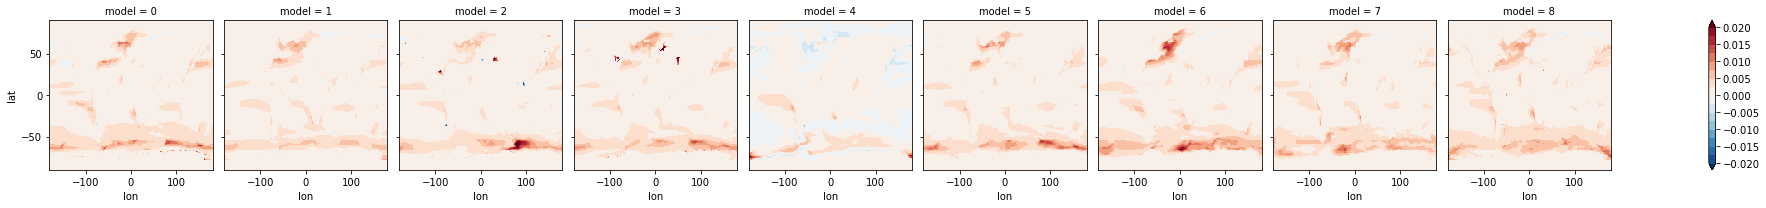

In [22]:
beta_ocean_all.plot(x='lon',y='lat', col='model', levels=np.arange(-.02,.0225,0.0025))

#### show maps of the ocean gamma for all models

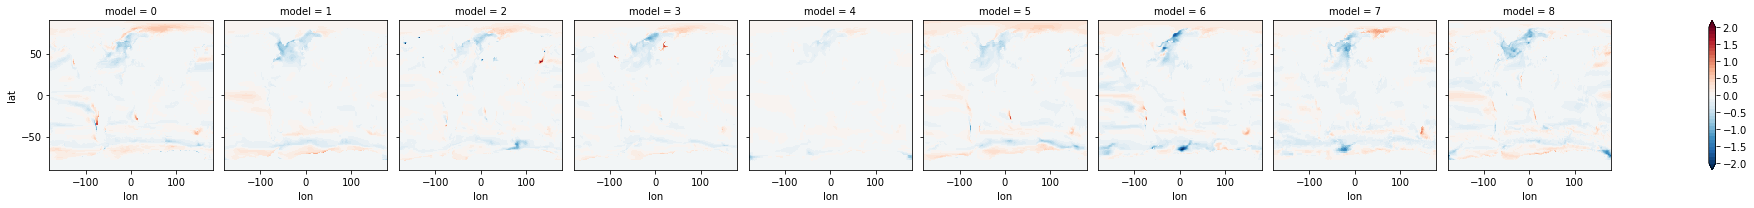

In [23]:
gamma_ocean_all.plot(x='lon',y='lat', col='model', levels=np.arange(-2,2.1,0.1))

#### show maps of the ocean and land beta for all models

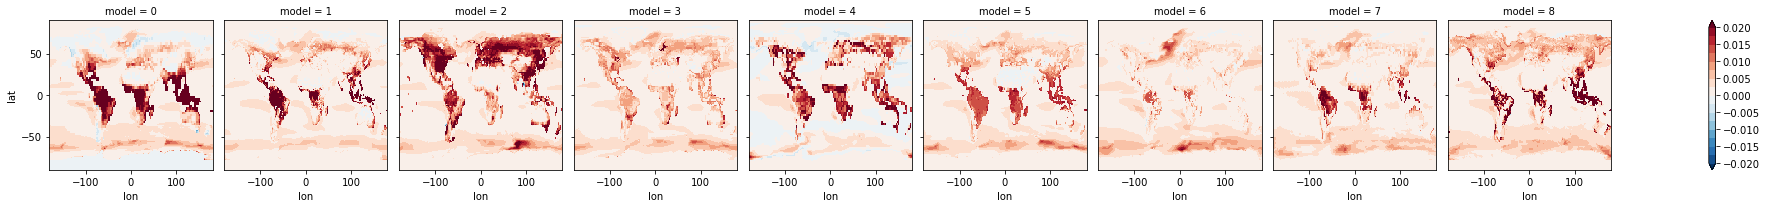

In [24]:
beta_all.plot(x='lon',y='lat', col='model', levels=np.arange(-.02,.0225,0.0025))

#### show maps of the ocean and land gamma for all models

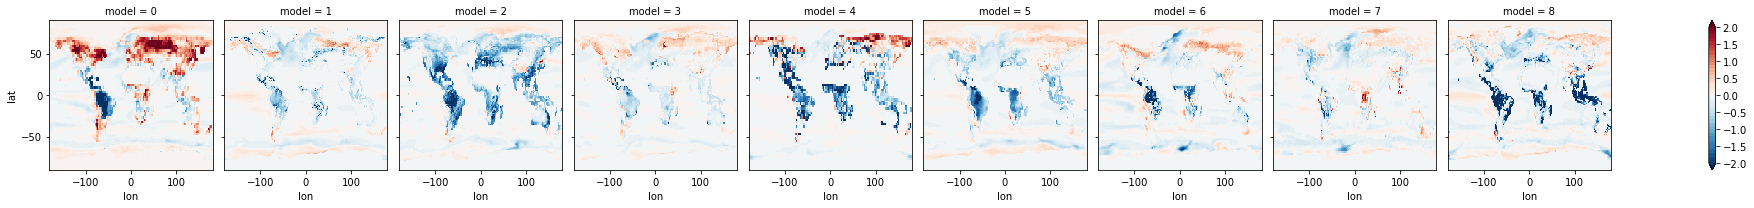

In [25]:
gamma_all.plot(x='lon',y='lat', col='model', levels=np.arange(-2,2.1,0.1))

#### show maps of the change in land carbon during the fully coupled run for all models

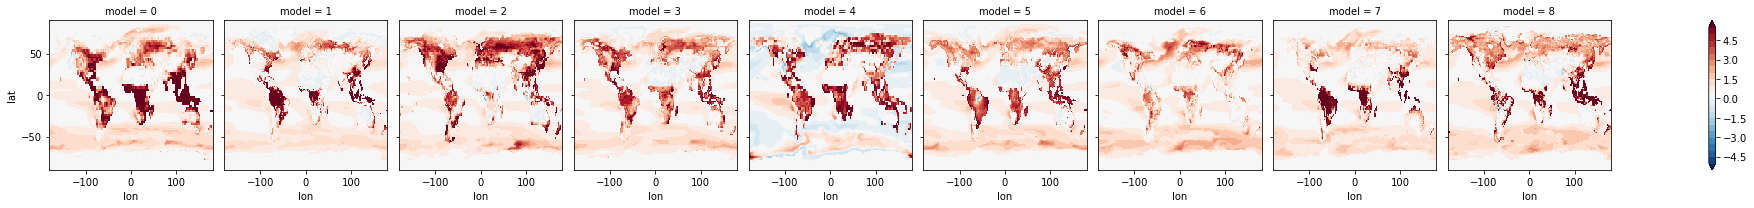

In [26]:
deltac_all.plot(x='lon',y='lat', col='model', levels=np.arange(-5,6,0.5))

#### show maps of the preindustrial land-sea CO2 flux for all models

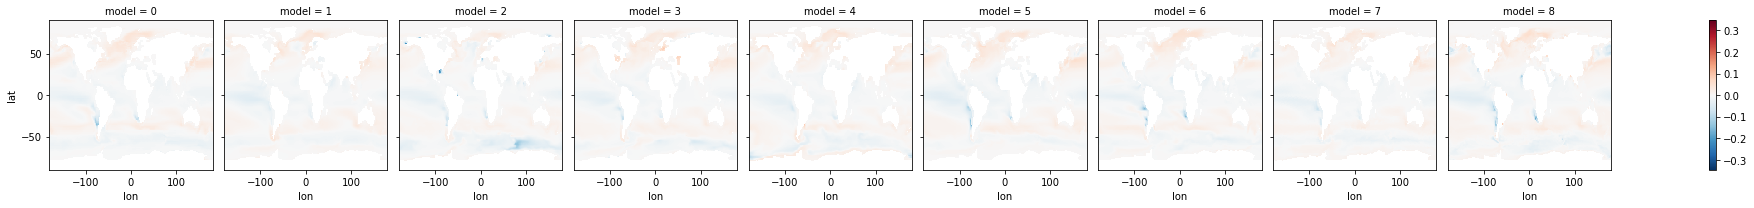

In [27]:
fgco2_picontrol_all.plot(x='lon',y='lat', col='model')

#### calculate multi-model ensemble mean, geographically-resolved beta and gamma values

In [28]:
beta_mean = beta_all.mean(dim='model')
gamma_mean = gamma_all.mean(dim='model')

beta_land_mean = beta_land_all.mean(dim='model')
beta_ocean_mean = beta_ocean_all.mean(dim='model')

gamma_land_mean = gamma_land_all.mean(dim='model')
gamma_ocean_mean = gamma_ocean_all.mean(dim='model')

#### show a map of the multi-model mean beta

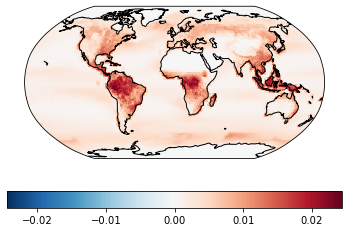

In [29]:
fg = beta_mean.plot(x='lon',y='lat', transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.Robinson()), cbar_kwargs={'orientation': 'horizontal'})
fg.axes.coastlines()

In [30]:
### show a map of the multi-model mean gamma

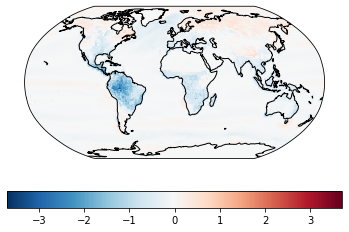

In [31]:
fg = gamma_mean.plot(x='lon',y='lat', transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.Robinson()), cbar_kwargs={'orientation': 'horizontal'})
fg.axes.coastlines()

#### calculate agreement via stipling where xx% of the models agree in sign with the model mean

In [32]:
stipling_agreement_fraction = 0.80

sign_agreement_beta = (np.sign(beta_all) == np.sign(beta_mean)).mean(dim='model')
sign_agreement_gamma = (np.sign(gamma_all) == np.sign(gamma_mean)).mean(dim='model')
#print(sign_agreement_gamma)

#### make a map of model sign agreement in delta carbon

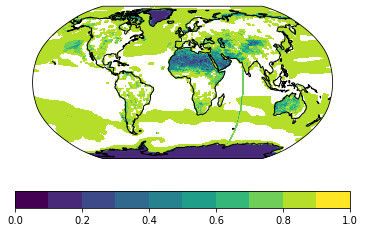

In [33]:
sign_agreement_deltac = (np.sign(deltac_all) == np.sign(deltac_all.mean(dim='model'))).mean(dim='model')
fg = sign_agreement_deltac.plot(x='lon',y='lat', transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.Robinson()), levels=np.arange(11)/10., cbar_kwargs={'orientation': 'horizontal'})
fg.axes.coastlines()

#### make a map of model sign agreement in beta

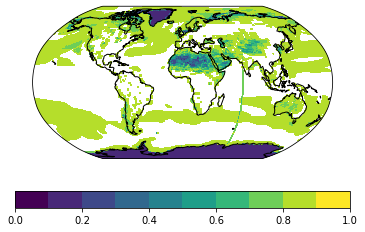

In [34]:
fg = sign_agreement_beta.plot(x='lon',y='lat', transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.Robinson()), levels=np.arange(11)/10., cbar_kwargs={'orientation': 'horizontal'})
fg.axes.coastlines()

#fg.axes.contourf(beta_all.lon,beta_all.lat,sign_agreement_beta,levels=[0.,stipling_agreement_fraction, 1.],
#             colors='none',
#             hatches=[None,'...'],
#             transform=ccrs.PlateCarree(), alpha=0.)
matplotlib.pyplot.savefig('betasignagreement', dpi=600)

#### make a map of model sign agreement in gamma

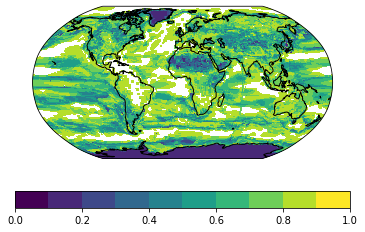

In [35]:
fg = sign_agreement_gamma.plot(x='lon',y='lat', transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.Robinson()), levels=np.arange(11)/10., cbar_kwargs={'orientation': 'horizontal'})
fg.axes.coastlines()

#fg.axes.contourf(beta_all.lon,beta_all.lat,sign_agreement_beta,levels=[0.,stipling_agreement_fraction, 1.],
#             colors='none',
#             hatches=[None,'...'],
#             transform=ccrs.PlateCarree(), alpha=0.)
matplotlib.pyplot.savefig('gammasignagreement', dpi=600)

#### make a map of beta with stippling for agreement

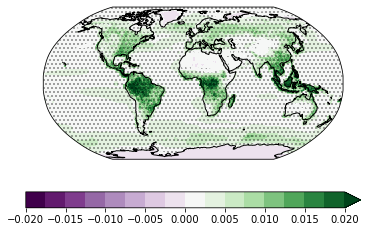

In [36]:
fg = beta_all.mean(dim='model').plot(x='lon',y='lat', transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.Robinson()), levels=np.arange(-.02,.0225,0.0025), cmap='PRGn', cbar_kwargs={'orientation': 'horizontal'})
fg.axes.coastlines()

fg.axes.contourf(sign_agreement_beta.lon,sign_agreement_beta.lat,1.-sign_agreement_beta,levels=[0.,1.-stipling_agreement_fraction],
             antialiased = False,
             extend ='neither',
             colors='white',
             hatches=['...'],
             transform=ccrs.PlateCarree(), alpha=0.0)
matplotlib.pyplot.savefig('beta3', dpi=600)

#### make a map of gamma with stippling for agreement

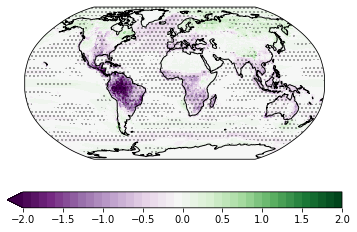

In [37]:
fg = gamma_all.mean(dim='model').plot(x='lon',y='lat', transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.Robinson()), levels=np.arange(-2,2.1,0.1), cmap='PRGn', cbar_kwargs={'orientation': 'horizontal'})
fg.axes.coastlines()

fg.axes.contourf(gamma_all.lon,gamma_all.lat,1.-sign_agreement_gamma,levels=[0.,1.-stipling_agreement_fraction],
             colors='none',
             hatches=['...'],
             transform=ccrs.PlateCarree(), alpha=0.00)

matplotlib.pyplot.savefig('gamma3', dpi=600)

#### calculate zonal-mean values for beta

In [38]:

n_zonalmean_curves = 2
zonalmean_beta_curves = np.zeros([n_zonalmean_curves,JM_o])
zonalmean_beta_curves_min = np.zeros([n_zonalmean_curves,JM_o])
zonalmean_beta_curves_max = np.zeros([n_zonalmean_curves,JM_o])

zonalmean_beta_curves[0,:] = beta_land_mean.mean(dim='lon')
zonalmean_beta_curves[1,:] = beta_ocean_mean.mean(dim='lon')

zonalmean_beta_curves_min[0,:] = beta_land_mean.mean(dim='lon') - beta_land_all.std(dim='model').mean(dim='lon')
zonalmean_beta_curves_min[1,:] = beta_ocean_mean.mean(dim='lon') - beta_ocean_all.std(dim='model').mean(dim='lon')

zonalmean_beta_curves_max[0,:] = beta_land_mean.mean(dim='lon') + beta_land_all.std(dim='model').mean(dim='lon')
zonalmean_beta_curves_max[1,:] = beta_ocean_mean.mean(dim='lon') + beta_ocean_all.std(dim='model').mean(dim='lon')




#### calculate zonal-mean values for gamma

In [39]:
zonalmean_gamma_curves = np.zeros([n_zonalmean_curves,JM_o])
zonalmean_gamma_curves[0,:] = gamma_land_mean.mean(axis=1)
zonalmean_gamma_curves[1,:] = gamma_ocean_mean.mean(axis=1)

zonalmean_gamma_curves_min = np.zeros([n_zonalmean_curves,JM_o])
zonalmean_gamma_curves_max = np.zeros([n_zonalmean_curves,JM_o])

zonalmean_gamma_curves_min[0,:] = gamma_land_mean.mean(dim='lon') - gamma_land_all.std(dim='model').mean(dim='lon')
zonalmean_gamma_curves_min[1,:] = gamma_ocean_mean.mean(dim='lon') - gamma_ocean_all.std(dim='model').mean(dim='lon')

zonalmean_gamma_curves_max[0,:] = gamma_land_mean.mean(dim='lon') + gamma_land_all.std(dim='model').mean(dim='lon')
zonalmean_gamma_curves_max[1,:] = gamma_ocean_mean.mean(dim='lon') + gamma_ocean_all.std(dim='model').mean(dim='lon')


#### calculate zonal-mean values for gamma for models with permafrost carbon (here, only one model)

In [40]:
zonalmean_gamma_land_curves_permafrost = gamma_land_all.isel(model=models_list.index('CESM2')).mean(dim='lon')

#### calculate zonal-mean values for gamma and beta for models with and without nitrogen cycles

In [41]:
zonalmean_gamma_land_curves_nitrogen = gamma_land_all[land_n_cycle].mean(dim='model').mean(dim='lon')
zonalmean_beta_land_curves_nitrogen = beta_land_all[land_n_cycle].mean(dim='model').mean(dim='lon')

zonalmean_gamma_land_curves_conly = gamma_land_all[np.logical_not(land_n_cycle)].mean(dim='model').mean(dim='lon')
zonalmean_beta_land_curves_conly = beta_land_all[np.logical_not(land_n_cycle)].mean(dim='model').mean(dim='lon')

#### plot everything together in a row

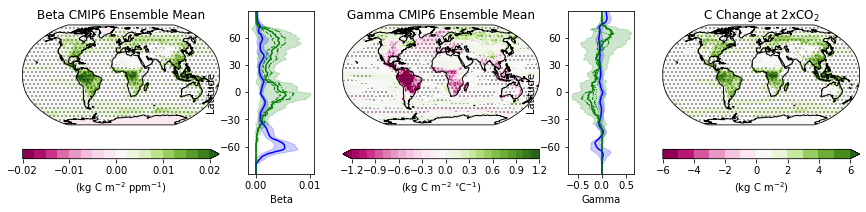

In [42]:
fig = plt.figure(figsize=(15, 3))
map_widths = 3
fig_widths = 1
#map_heights = 3
#fig_heights = 3
gs = fig.add_gridspec(nrows=1,ncols=5, width_ratios=[map_widths,fig_widths,map_widths,fig_widths,map_widths])#, height_ratios=[map_heights,fig_heights,map_heights,fig_heights,map_heights])

ax1 = fig.add_subplot(gs[0], projection=ccrs.Robinson())
fg = beta_all.mean(dim='model').plot(ax=ax1, x='lon',y='lat', transform=ccrs.PlateCarree(), levels=np.arange(-.02,.0225,0.0025), cmap='PiYG', cbar_kwargs={'orientation': 'horizontal', 'label': '(kg C m$^{-2}$ ppm$^{-1}$)', 'ticks': [-.02,-.01,0,.01,.02]})
ax1.coastlines()
ax1.contourf(sign_agreement_beta.lon,sign_agreement_beta.lat,1.-sign_agreement_beta,levels=[0.,1.-stipling_agreement_fraction],
             antialiased = False,
             extend ='neither',
             colors='white',
             hatches=['...'], density=0.1,
             transform=ccrs.PlateCarree(), alpha=0.0)
ax1.set_title('Beta CMIP6 Ensemble Mean')


ax2 = fig.add_subplot(gs[2], projection=ccrs.Robinson())
fg = gamma_all.mean(dim='model').plot(ax=ax2, x='lon',y='lat', transform=ccrs.PlateCarree(), levels=np.arange(-1.2,1.3,0.1), cmap='PiYG', cbar_kwargs={'orientation': 'horizontal', 'label': '(kg C m$^{-2}$ $^{\circ}$C$^{-1}$)'})
ax2.coastlines()
ax2.contourf(gamma_all.lon,gamma_all.lat,1.-sign_agreement_gamma,levels=[0.,1.-stipling_agreement_fraction],
             colors='none',
             hatches=['...'], density=0.1,
             transform=ccrs.PlateCarree(), alpha=0.00)
ax2.set_title('Gamma CMIP6 Ensemble Mean')


ax3 = fig.add_subplot(gs[1])
p1 = ax3.plot(zonalmean_beta_curves.transpose(), regrid_lats)
ax3.fill_betweenx(regrid_lats, zonalmean_beta_curves_min[0,:], zonalmean_beta_curves_max[0,:], color='green', alpha=0.2)
ax3.fill_betweenx(regrid_lats, zonalmean_beta_curves_min[1,:], zonalmean_beta_curves_max[1,:], color='blue', alpha=0.2)
plt.setp(p1[0], color='green')
plt.setp(p1[1], color='blue') 
ax3.plot(zonalmean_beta_land_curves_nitrogen, regrid_lats, color='green', linestyle='dashed', linewidth=1.0)
ax3.plot(zonalmean_beta_land_curves_conly, regrid_lats, color='green', linestyle='-.', linewidth=1.0)
ax3.set_xlabel('Beta')
ax3.set_ylabel('Latitude')
ax3.set_yticks((-60,-30,0,30,60))
ax3.set_ylim((-90,90))

ax4 = fig.add_subplot(gs[3])
p2 = ax4.plot(zonalmean_gamma_curves.transpose(), regrid_lats)
ax4.fill_betweenx(regrid_lats, zonalmean_gamma_curves_min[0,:], zonalmean_gamma_curves_max[0,:], color='green', alpha=0.2)
ax4.fill_betweenx(regrid_lats, zonalmean_gamma_curves_min[1,:], zonalmean_gamma_curves_max[1,:], color='blue', alpha=0.2)
plt.setp(p2[0], color='green')
plt.setp(p2[1], color='blue') 
ax4.plot(zonalmean_gamma_land_curves_permafrost, regrid_lats, color='green', linestyle='dotted', linewidth=1.0)
ax4.plot(zonalmean_gamma_land_curves_nitrogen, regrid_lats, color='green', linestyle='dashed', linewidth=1.0)
ax4.plot(zonalmean_gamma_land_curves_conly, regrid_lats, color='green', linestyle='-.', linewidth=1.0)
ax4.set_xlabel('Gamma')
ax4.set_ylabel('Latitude')
ax4.set_yticks((-60,-30,0,30,60))
ax4.set_ylim((-90,90))

ax5 = fig.add_subplot(gs[4], projection=ccrs.Robinson())
fg = deltac_all.mean(dim='model').plot(ax=ax5, x='lon',y='lat', transform=ccrs.PlateCarree(), levels=np.arange(-6,7,1), cmap='PiYG', cbar_kwargs={'orientation': 'horizontal', 'label': '(kg C m$^{-2}$)'})
ax5.set_title('C Change at 2xCO$_2$')
ax5.coastlines()
ax5.contourf(deltac_all.lon,deltac_all.lat,1.-sign_agreement_deltac,levels=[0.,1.-stipling_agreement_fraction],
             colors='none',
             hatches=['...'], density=0.1,
             transform=ccrs.PlateCarree(), alpha=0.00)

fig.savefig('betagammamaps1.png', dpi=300, format='png')
fig.savefig('betagammamaps1.pdf', format='pdf')

#fig.tight_layout()

#### plot everything together in a more complex arrangement to indicate the linearly additive nature of beta and gamma to delta C.

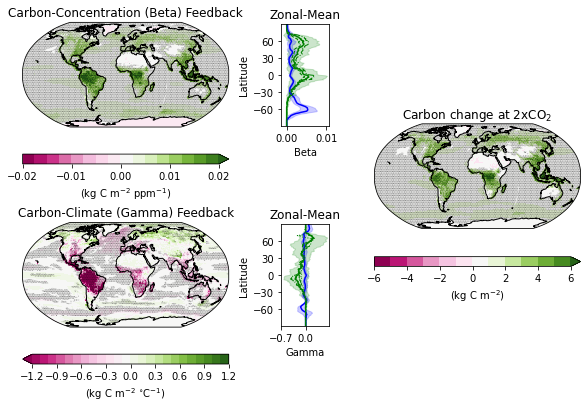

In [43]:
fig = plt.figure(figsize=(10, 7))
map_widths = 3.
fig_widths = 0.7
map_height = 3.
fig_topoffset = 0.3
fig_botoffset = 0.9
map_fig_space = 0.2
vspace_betweenmaps = 0.1
hspace_toright_offig = 0.1
y1 = fig_topoffset
y2 = map_height/2. + vspace_betweenmaps/2.
y3 = map_height - fig_botoffset
y4 = map_height
y5 = map_height + vspace_betweenmaps
y6 = map_height + vspace_betweenmaps + fig_topoffset
y7 = map_height + vspace_betweenmaps/2. + map_height/2.
y8 = map_height + vspace_betweenmaps + map_height - fig_botoffset
y9 = map_height + vspace_betweenmaps + map_height
#map_heights = 3
#fig_heights = 3
gs = fig.add_gridspec(nrows=9,ncols=5, width_ratios=[map_widths,map_fig_space,fig_widths,hspace_toright_offig,map_widths], height_ratios=[y1, y2-y1, y3-y2, y4-y3, y5-y4, y6-y5, y7-y6, y8-y7, y9-y8])

ax1 = fig.add_subplot(gs[0:4, 0], projection=ccrs.Robinson())
fg = beta_all.mean(dim='model').plot(ax=ax1, x='lon',y='lat', transform=ccrs.PlateCarree(), levels=np.arange(-.02,.0225,0.0025), cmap='PiYG', cbar_kwargs={'orientation': 'horizontal', 'label': '(kg C m$^{-2}$ ppm$^{-1}$)', 'ticks': [-.02,-.01,0,.01,.02]})
ax1.coastlines()
ax1.contourf(sign_agreement_beta.lon,sign_agreement_beta.lat,1.-sign_agreement_beta,levels=[0.,1.-stipling_agreement_fraction],
             antialiased = False,
             extend ='neither',
             colors='white',
             hatches=['.......'],
             transform=ccrs.PlateCarree(), alpha=0.0)
ax1.set_title('Carbon-Concentration (Beta) Feedback')


ax2 = fig.add_subplot(gs[5:9, 0], projection=ccrs.Robinson())
fg = gamma_all.mean(dim='model').plot(ax=ax2, x='lon',y='lat', transform=ccrs.PlateCarree(), levels=np.arange(-1.2,1.3,0.1), cmap='PiYG', cbar_kwargs={'orientation': 'horizontal', 'label': '(kg C m$^{-2}$ $^{\circ}$C$^{-1}$)'})
ax2.coastlines()
ax2.contourf(gamma_all.lon,gamma_all.lat,1.-sign_agreement_gamma,levels=[0.,1.-stipling_agreement_fraction],
             colors='none',
             hatches=['.......'],
             transform=ccrs.PlateCarree(), alpha=0.00)
ax2.set_title('Carbon-Climate (Gamma) Feedback')


ax3 = fig.add_subplot(gs[1:3, 2])
p1 = ax3.plot(zonalmean_beta_curves.transpose(), regrid_lats)
ax3.fill_betweenx(regrid_lats, zonalmean_beta_curves_min[0,:], zonalmean_beta_curves_max[0,:], color='green', alpha=0.2)
ax3.fill_betweenx(regrid_lats, zonalmean_beta_curves_min[1,:], zonalmean_beta_curves_max[1,:], color='blue', alpha=0.2)
plt.setp(p1[0], color='green')
plt.setp(p1[1], color='blue') 
ax3.plot(zonalmean_beta_land_curves_nitrogen, regrid_lats, color='green', linestyle='dashed', linewidth=1.0)
ax3.plot(zonalmean_beta_land_curves_conly, regrid_lats, color='green', linestyle='-.', linewidth=1.0)
ax3.set_title('Zonal-Mean')
ax3.set_xlabel('Beta')
ax3.set_ylabel('Latitude')
ax3.set_yticks((-60,-30,0,30,60))
ax3.set_ylim((-90,90))

ax4 = fig.add_subplot(gs[6:8, 2])
p2 = ax4.plot(zonalmean_gamma_curves.transpose(), regrid_lats)
ax4.fill_betweenx(regrid_lats, zonalmean_gamma_curves_min[0,:], zonalmean_gamma_curves_max[0,:], color='green', alpha=0.2)
ax4.fill_betweenx(regrid_lats, zonalmean_gamma_curves_min[1,:], zonalmean_gamma_curves_max[1,:], color='blue', alpha=0.2)
plt.setp(p2[0], color='green')
plt.setp(p2[1], color='blue') 
ax4.plot(zonalmean_gamma_land_curves_permafrost, regrid_lats, color='green', linestyle='dotted', linewidth=1.0)
ax4.plot(zonalmean_gamma_land_curves_nitrogen, regrid_lats, color='green', linestyle='dashed', linewidth=1.0)
ax4.plot(zonalmean_gamma_land_curves_conly, regrid_lats, color='green', linestyle='-.', linewidth=1.0)
#plt.legend(['Land', 'Ocean'], frameon=False)
ax4.set_title('Zonal-Mean')
ax4.set_xlabel('Gamma')
ax4.set_ylabel('Latitude')
ax4.set_xticks((-0.7,0.))
ax4.set_yticks((-60,-30,0,30,60))
ax4.set_ylim((-90,90))

ax5 = fig.add_subplot(gs[2:7, 4], projection=ccrs.Robinson())
fg = deltac_all.mean(dim='model').plot(ax=ax5, x='lon',y='lat', transform=ccrs.PlateCarree(), levels=np.arange(-6,7,1), cmap='PiYG', cbar_kwargs={'orientation': 'horizontal', 'label': '(kg C m$^{-2}$)'})
ax5.set_title('C Change at 2xCO$_2$')
ax5.coastlines()
ax5.set_title('Carbon change at 2xCO$_2$')
ax5.contourf(deltac_all.lon,deltac_all.lat,1.-sign_agreement_deltac,levels=[0.,1.-stipling_agreement_fraction],
             colors='none',
             hatches=['.......'], 
             transform=ccrs.PlateCarree(), alpha=0.00)

fig.savefig('betagammamaps2.png', dpi=300, format='png')
fig.savefig('betagammamaps2.pdf', format='pdf')
#fig.tight_layout()

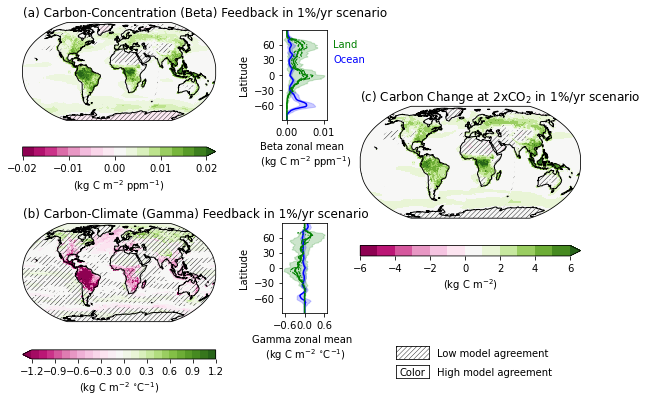

In [44]:
fig = plt.figure(figsize=(10, 7))
map_widths = 3.
fig_widths = 0.7
map_height = 3.
fig_topoffset = 0.5
fig_botoffset = 0.9
map_fig_space = 0.6
vspace_betweenmaps = 0.1
hspace_toright_offig = 0.1
boxheights = 0.25
boxwidth = 0.5
boxleftpadding = 0.35
y1 = fig_topoffset
y2 = map_height/2. + vspace_betweenmaps/2.
y3 = map_height - fig_botoffset
y4 = map_height
y5 = map_height + vspace_betweenmaps
y6 = map_height + vspace_betweenmaps + fig_topoffset
y7 = map_height + vspace_betweenmaps/2. + map_height/2.
y8 = map_height + vspace_betweenmaps + map_height - fig_botoffset
y9 = map_height + vspace_betweenmaps + map_height - boxheights * 2
y10 = map_height + vspace_betweenmaps + map_height - boxheights * 1
y11 = map_height + vspace_betweenmaps + map_height

#map_heights = 3
#fig_heights = 3
gs = fig.add_gridspec(nrows=11,ncols=7, width_ratios=[map_widths,map_fig_space,fig_widths,hspace_toright_offig,boxleftpadding,boxwidth,map_widths-boxwidth-boxleftpadding], height_ratios=[y1, y2-y1, y3-y2, y4-y3, y5-y4, y6-y5, y7-y6, y8-y7, y9-y8,y10-y9,y11-y10])

matplotlib.rcParams['hatch.linewidth'] = 0.4

ax1 = fig.add_subplot(gs[0:4, 0], projection=ccrs.Robinson())
fg = beta_all.mean(dim='model').plot(ax=ax1, x='lon',y='lat', transform=ccrs.PlateCarree(), levels=np.arange(-.02,.0225,0.0025), cmap='PiYG', cbar_kwargs={'orientation': 'horizontal', 'label': '(kg C m$^{-2}$ ppm$^{-1}$)', 'ticks': [-.02,-.01,0,.01,.02]})
ax1.coastlines()
ax1.contourf(sign_agreement_beta.lon,sign_agreement_beta.lat,sign_agreement_beta,levels=[0.,stipling_agreement_fraction],
             antialiased = False,
             extend ='neither',
             colors='white',
             hatches=['/////'],
             transform=ccrs.PlateCarree(), alpha=0.0)
ax1.contourf(beta_all.lon,beta_all.lat,beta_all.mean(dim='model'), levels=np.arange(-.02,.0225,0.0025), cmap='PiYG', transform=ccrs.PlateCarree(), alpha=0.00)
ax1.set_title('(a) Carbon-Concentration (Beta) Feedback in 1%/yr scenario', fontdict={'horizontalalignment':'left'}, loc='left')


ax2 = fig.add_subplot(gs[5:11, 0], projection=ccrs.Robinson())
fg = gamma_all.mean(dim='model').plot(ax=ax2, x='lon',y='lat', transform=ccrs.PlateCarree(), levels=np.arange(-1.2,1.3,0.1), cmap='PiYG', cbar_kwargs={'orientation': 'horizontal', 'label': '(kg C m$^{-2}$ $^{\circ}$C$^{-1}$)'})
ax2.coastlines()
ax2.contourf(gamma_all.lon,gamma_all.lat,sign_agreement_gamma,levels=[0.,stipling_agreement_fraction],
             colors='none',
             hatches=['/////'],
             linewidths=0.5,
             transform=ccrs.PlateCarree(), alpha=0.00)
ax2.set_title('(b) Carbon-Climate (Gamma) Feedback in 1%/yr scenario', fontdict={'horizontalalignment':'left'}, loc='left')


ax3 = fig.add_subplot(gs[1:3, 2])
p1 = ax3.plot(zonalmean_beta_curves.transpose(), regrid_lats)
ax3.fill_betweenx(regrid_lats, zonalmean_beta_curves_min[0,:], zonalmean_beta_curves_max[0,:], color='green', alpha=0.2)
ax3.fill_betweenx(regrid_lats, zonalmean_beta_curves_min[1,:], zonalmean_beta_curves_max[1,:], color='blue', alpha=0.2)
plt.setp(p1[0], color='green')
plt.setp(p1[1], color='blue') 
ax3.plot(zonalmean_beta_land_curves_nitrogen, regrid_lats, color='green', linestyle='dashed', linewidth=1.0)
ax3.plot(zonalmean_beta_land_curves_conly, regrid_lats, color='green', linestyle='-.', linewidth=1.0)
#ax3.set_title('Zonal-Mean')
ax3.set_xlabel('Beta zonal mean \n (kg C m$^{-2}$ ppm$^{-1}$)')
ax3.set_ylabel('Latitude')
ax3.set_yticks((-60,-30,0,30,60))
ax3.set_ylim((-90,90))
ax3.text(.0125,60,'Land', verticalalignment='center', color='green')
ax3.text(.0125,30,'Ocean', verticalalignment='center', color='blue')


ax4 = fig.add_subplot(gs[6:8, 2])
p2 = ax4.plot(zonalmean_gamma_curves.transpose(), regrid_lats)
ax4.fill_betweenx(regrid_lats, zonalmean_gamma_curves_min[0,:], zonalmean_gamma_curves_max[0,:], color='green', alpha=0.2)
ax4.fill_betweenx(regrid_lats, zonalmean_gamma_curves_min[1,:], zonalmean_gamma_curves_max[1,:], color='blue', alpha=0.2)
plt.setp(p2[0], color='green')
plt.setp(p2[1], color='blue') 
ax4.plot(zonalmean_gamma_land_curves_permafrost, regrid_lats, color='green', linestyle='dotted', linewidth=1.0)
ax4.plot(zonalmean_gamma_land_curves_nitrogen, regrid_lats, color='green', linestyle='dashed', linewidth=1.0)
ax4.plot(zonalmean_gamma_land_curves_conly, regrid_lats, color='green', linestyle='-.', linewidth=1.0)
#plt.legend(['Land', 'Ocean'], frameon=False)
#ax4.set_title('Zonal-Mean')
ax4.set_xlabel('Gamma zonal mean \n (kg C m$^{-2}$ $^{\circ}$C$^{-1}$)')
ax4.set_ylabel('Latitude')
ax4.set_xticks((-0.6,0.,0.6))
ax4.set_yticks((-60,-30,0,30,60))
ax4.set_ylim((-90,90))

ax5 = fig.add_subplot(gs[2:7, 4:7], projection=ccrs.Robinson())
fg = deltac_all.mean(dim='model').plot(ax=ax5, x='lon',y='lat', transform=ccrs.PlateCarree(), levels=np.arange(-6,7,1), cmap='PiYG', cbar_kwargs={'orientation': 'horizontal', 'label': '(kg C m$^{-2}$)'})
ax5.set_title('(c) Carbon Change at 2xCO$_2$ in 1%/yr scenario', fontdict={'horizontalalignment':'left'}, loc='left')
ax5.coastlines()
ax5.contourf(deltac_all.lon,deltac_all.lat,sign_agreement_deltac,levels=[0.,stipling_agreement_fraction],
             colors='none',
             hatches=['/////'], 
             transform=ccrs.PlateCarree(), alpha=0.00)
ax5.contourf(deltac_all.lon,deltac_all.lat,deltac_all.mean(dim='model'), levels=np.arange(-6,7,1), cmap='PiYG', transform=ccrs.PlateCarree(), alpha=0.00)


ax6 = fig.add_subplot(gs[9:10, 5])
ax6.contourf([0,1,2],[0,1,2],np.ones((3,3))*0.,levels=[0.,stipling_agreement_fraction],
             colors='none',
             hatches=['/////'], 
             alpha=0.00)
ax6.xaxis.set_visible(False)
ax6.yaxis.set_visible(False)
ax6.text(2.5,0.9,'Low model agreement', verticalalignment='center')

ax7 = fig.add_subplot(gs[10:11, 5])
ax7.contourf([0,1,2],[0,1,2],np.ones((3,3))*1.,levels=[0.,stipling_agreement_fraction],
             colors='none',
             hatches=['/////'], 
             alpha=0.00)
ax7.xaxis.set_visible(False)
ax7.yaxis.set_visible(False)
ax7.text(2.5,0.9,'High model agreement', verticalalignment='center')
ax7.text(1,0.9,'Color', verticalalignment='center', horizontalalignment='center')


fig.savefig('betagammamaps3.png', dpi=300, format='png')
fig.savefig('betagammamaps3.pdf', format='pdf')
#fig.tight_layout()

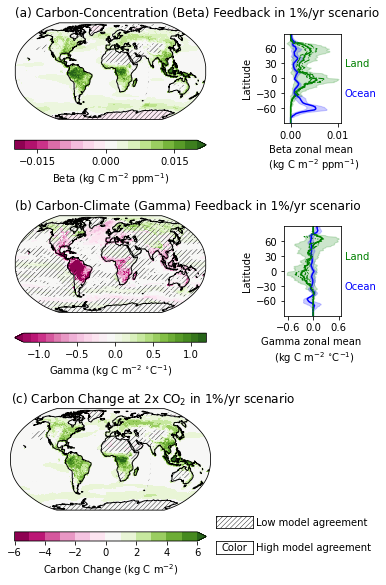

In [45]:
fig = plt.figure(figsize=(7, 10))
map_widths = 2
fig_widths = 0.2
map_height = 3.
fig_topoffset = 0.1
fig_botoffset = 0.75
map_fig_space = 0.1
vspace_betweenmaps = 1.
hspace_toright_offig = 0.1
boxheights = 0.3
boxwidth = 0.25
boxrightpadding = 0.03
y0 = fig_topoffset
y1 = map_height - fig_botoffset
y2 = map_height
y3 = map_height + vspace_betweenmaps
y4 = map_height + vspace_betweenmaps + fig_topoffset
y5 = map_height + vspace_betweenmaps + map_height - fig_botoffset
y6 = map_height + vspace_betweenmaps + map_height
y7 = map_height + vspace_betweenmaps + map_height + vspace_betweenmaps
y8 = map_height + vspace_betweenmaps + map_height + vspace_betweenmaps + 0.001
y9 = map_height + vspace_betweenmaps + map_height + vspace_betweenmaps + map_height - 2.5*boxheights
y10 = map_height + vspace_betweenmaps + map_height + vspace_betweenmaps + map_height - 1.5*boxheights
y11 = map_height + vspace_betweenmaps + map_height + vspace_betweenmaps + map_height - 1.5*boxheights
y12 = map_height + vspace_betweenmaps + map_height + vspace_betweenmaps + map_height - 0.5*boxheights
y13 = map_height + vspace_betweenmaps + map_height + vspace_betweenmaps + map_height




cbar_shrink = 0.6
#map_heights = 3
#fig_heights = 3
gs = fig.add_gridspec(nrows=14,ncols=5, width_ratios=[map_widths-boxwidth-boxrightpadding,boxwidth,boxrightpadding,map_fig_space,fig_widths], height_ratios=[y0, y1-y0, y2-y1, y3-y2, y4-y3, y5-y4, y6-y5, y7-y6, y8-y7, y9-y8, y10-y9, y11-y10, y12-y11, y13-y12])

matplotlib.rcParams['hatch.linewidth'] = 0.4

ax1 = fig.add_subplot(gs[0:3,0:3], projection=ccrs.Robinson())
fg = beta_all.mean(dim='model').plot(ax=ax1, x='lon',y='lat', transform=ccrs.PlateCarree(), levels=np.arange(-.02,.0225,0.0025), cmap='PiYG', cbar_kwargs={'orientation': 'horizontal', 'label': 'Beta (kg C m$^{-2}$ ppm$^{-1}$)', 'ticks': [-.015,0,.015], 'shrink':cbar_shrink})
ax1.coastlines()
ax1.contourf(sign_agreement_beta.lon,sign_agreement_beta.lat,sign_agreement_beta,levels=[0.,stipling_agreement_fraction],
             antialiased = False,
             extend ='neither',
             colors='white',
             hatches=['/////'],
             transform=ccrs.PlateCarree(), alpha=0.0)
ax1.contourf(beta_all.lon,beta_all.lat,beta_all.mean(dim='model'), levels=np.arange(-.02,.0225,0.0025), cmap='PiYG', transform=ccrs.PlateCarree(), alpha=0.00)
ax1.set_title('(a) Carbon-Concentration (Beta) Feedback in 1%/yr scenario', fontdict={'horizontalalignment':'left'}, loc='left')


ax2 = fig.add_subplot(gs[4:7, 0:3], projection=ccrs.Robinson())
fg = gamma_all.mean(dim='model').plot(ax=ax2, x='lon',y='lat', transform=ccrs.PlateCarree(), levels=np.arange(-1.2,1.3,0.1), cmap='PiYG', cbar_kwargs={'orientation': 'horizontal', 'label': 'Gamma (kg C m$^{-2}$ $^{\circ}$C$^{-1}$)','ticks': [-1,-.5,0.,.5,1.], 'shrink':cbar_shrink})
ax2.coastlines()
ax2.contourf(gamma_all.lon,gamma_all.lat,sign_agreement_gamma,levels=[0.,stipling_agreement_fraction],
             colors='none',
             hatches=['/////'],
             linewidths=0.5,
             transform=ccrs.PlateCarree(), alpha=0.00)
ax2.set_title('(b) Carbon-Climate (Gamma) Feedback in 1%/yr scenario', fontdict={'horizontalalignment':'left'}, loc='left')


ax3 = fig.add_subplot(gs[1:2, 3:])
p1 = ax3.plot(zonalmean_beta_curves.transpose(), regrid_lats)
ax3.fill_betweenx(regrid_lats, zonalmean_beta_curves_min[0,:], zonalmean_beta_curves_max[0,:], color='green', alpha=0.2)
ax3.fill_betweenx(regrid_lats, zonalmean_beta_curves_min[1,:], zonalmean_beta_curves_max[1,:], color='blue', alpha=0.2)
plt.setp(p1[0], color='green')
plt.setp(p1[1], color='blue') 
ax3.plot(zonalmean_beta_land_curves_nitrogen, regrid_lats, color='green', linestyle='dashed', linewidth=1.0)
ax3.plot(zonalmean_beta_land_curves_conly, regrid_lats, color='green', linestyle='-.', linewidth=1.0)
#ax3.set_title('Zonal-Mean')
ax3.set_xlabel('Beta zonal mean \n (kg C m$^{-2}$ ppm$^{-1}$)')
ax3.set_ylabel('Latitude')
ax3.set_yticks((-60,-30,0,30,60))
ax3.set_ylim((-90,90))
ax3.text(.0115,30,'Land', verticalalignment='center', color='green')
ax3.text(.0115,-30,'Ocean', verticalalignment='center', color='blue')

ax4 = fig.add_subplot(gs[5:6, 3:])
p2 = ax4.plot(zonalmean_gamma_curves.transpose(), regrid_lats)
ax4.fill_betweenx(regrid_lats, zonalmean_gamma_curves_min[0,:], zonalmean_gamma_curves_max[0,:], color='green', alpha=0.2)
ax4.fill_betweenx(regrid_lats, zonalmean_gamma_curves_min[1,:], zonalmean_gamma_curves_max[1,:], color='blue', alpha=0.2)
plt.setp(p2[0], color='green')
plt.setp(p2[1], color='blue') 
ax4.plot(zonalmean_gamma_land_curves_permafrost, regrid_lats, color='green', linestyle='dotted', linewidth=1.0)
ax4.plot(zonalmean_gamma_land_curves_nitrogen, regrid_lats, color='green', linestyle='dashed', linewidth=1.0)
ax4.plot(zonalmean_gamma_land_curves_conly, regrid_lats, color='green', linestyle='-.', linewidth=1.0)
#plt.legend(['Land', 'Ocean'], frameon=False)
#ax4.set_title('Zonal-Mean')
ax4.set_xlabel('Gamma zonal mean \n (kg C m$^{-2}$ $^{\circ}$C$^{-1}$)')
ax4.set_ylabel('Latitude')
ax4.set_xticks((-0.6,0.,0.6))
ax4.set_yticks((-60,-30,0,30,60))
ax4.set_ylim((-90,90))
ax4.text(.75,30,'Land', verticalalignment='center', color='green')
ax4.text(.75,-30,'Ocean', verticalalignment='center', color='blue')

ax5 = fig.add_subplot(gs[8:13, 0:3], projection=ccrs.Robinson())
fg = deltac_all.mean(dim='model').plot(ax=ax5, x='lon',y='lat', transform=ccrs.PlateCarree(), levels=np.arange(-6,7,1), cmap='PiYG', cbar_kwargs={'orientation': 'horizontal', 'label': 'Carbon Change (kg C m$^{-2}$)', 'shrink':cbar_shrink})
ax5.set_title('(c) Carbon Change at 2x CO$_2$ in 1%/yr scenario', fontdict={'horizontalalignment':'left'}, loc='left')
ax5.coastlines()
ax5.contourf(deltac_all.lon,deltac_all.lat,sign_agreement_deltac,levels=[0.,stipling_agreement_fraction],
             colors='none',
             hatches=['/////'], 
             transform=ccrs.PlateCarree(), alpha=0.00)
ax5.contourf(deltac_all.lon,deltac_all.lat,deltac_all.mean(dim='model'), levels=np.arange(-6,7,1), cmap='PiYG', transform=ccrs.PlateCarree(), alpha=0.00)


ax6 = fig.add_subplot(gs[10, 1])
ax6.contourf([0,1,2],[0,1,2],np.ones((3,3))*0.,levels=[0.,stipling_agreement_fraction],
             colors='none',
             hatches=['/////'], 
             alpha=0.00)
ax6.xaxis.set_visible(False)
ax6.yaxis.set_visible(False)
ax6.text(2.2,0.9,'Low model agreement', verticalalignment='center')

ax7 = fig.add_subplot(gs[12, 1])
ax7.contourf([0,1,2],[0,1,2],np.ones((3,3))*1.,levels=[0.,stipling_agreement_fraction],
             colors='none',
             hatches=['/////'], 
             alpha=0.00)
ax7.xaxis.set_visible(False)
ax7.yaxis.set_visible(False)
ax7.text(2.2,0.9,'High model agreement', verticalalignment='center')
ax7.text(1,0.9,'Color', verticalalignment='center', horizontalalignment='center')


fig.savefig('betagammamaps4.png', dpi=300, format='png')
fig.savefig('betagammamaps4.pdf', format='pdf')
#fig.tight_layout()

#### save beta and gamma parameters as netcdf file for future work